In [6]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
import segmentation_models_pytorch as smp
import random
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size=4
image_count=50
img_size=512
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [2]:
test_image_list=glob('../../data/1-cycle_30%_중간데이터/segmentation/test/image/*.tiff')
test_tumor_mask_list=[f.replace('/image/', '/polygon/TP_tumor/') for f in test_image_list]
test_normal_mask_list=[f.replace('/image/', '/polygon/NT_normal/') for f in test_image_list]
train_image_list=glob('../../data/1-cycle_30%_중간데이터/segmentation/train/image/*.tiff')
train_tumor_mask_list=[f.replace('/image/', '/polygon/TP_tumor/') for f in train_image_list]
train_normal_mask_list=[f.replace('/image/', '/polygon/NT_normal/') for f in train_image_list]

class CustomDataset(Dataset):
    def __init__(self, image_list, label_list,count):
        self.img_path = image_list
        self.label = label_list

        self.count=count
    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        a=random.randint(0,len(self.img_path)-1)
        image_path = self.img_path[a]
        label_path =  self.label[a]
       
        
        return image_path, label_path
test_image=torch.zeros((len(test_image_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_tumor_mask_list),3,img_size,img_size))    
train_image=torch.zeros((len(train_image_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_tumor_mask_list),3,img_size,img_size))  
for i in tqdm(range(len(test_image))):
    image=1-tf(np.array(expand2square(Image.open(test_image_list[i]),(255,255,255)).resize((img_size,img_size))))
    test_image[i]=image
    msk_tumor=np.array((expand2square(Image.open(test_tumor_mask_list[i]),(0,0,0)).convert('L')).resize((img_size,img_size)))
    msk_normal=np.array((expand2square(Image.open(test_normal_mask_list[i]),(0,0,0)).convert('L')).resize((img_size,img_size)))
    msk_back=np.where((msk_tumor+msk_normal)==0,255,0)
    test_mask[i,0]=tf(msk_back)
    test_mask[i,1]=tf(msk_tumor)
    test_mask[i,2]=tf(msk_normal)

for i in tqdm(range(len(train_image))):
    image=1-tf(np.array(expand2square(Image.open(train_image_list[i]),(255,255,255)).resize((img_size,img_size))))
    train_image[i]=image
    msk_tumor=np.array((expand2square(Image.open(train_tumor_mask_list[i]),(0,0,0)).convert('L')).resize((img_size,img_size)))
    msk_normal=np.array((expand2square(Image.open(train_normal_mask_list[i]),(0,0,0)).convert('L')).resize((img_size,img_size)))
    msk_back=np.where((msk_tumor+msk_normal)==0,255,0)
    train_mask[i,0]=tf(msk_back)
    train_mask[i,1]=tf(msk_tumor)
    train_mask[i,2]=tf(msk_normal)
   
train_dataset = CustomDataset(train_image, train_mask,2660)

test_dataset = CustomDataset(test_image, test_mask,332)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/747 [00:00<?, ?it/s]

  0%|          | 0/3003 [00:00<?, ?it/s]

In [12]:
model=smp.UnetPlusPlus('efficientnet-b6', in_channels=3, classes=3).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=3):
    smooth = 1.
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)

        dice_per_class[class_id] = 1 - (2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return torch.mean(dice_per_class)



epoch: 1/30 Step: 666 dice_loss : 0.5085 dice_score: 0.4915: 100%|██████████| 665/665 [02:20<00:00,  4.74it/s]
Validation epoch: 1/30 Step: 84 dice_loss : 0.4683  dice_score: 0.5317: 100%|██████████| 83/83 [00:05<00:00, 15.69it/s]
epoch: 2/30 Step: 666 dice_loss : 0.4378 dice_score: 0.5622: 100%|██████████| 665/665 [02:20<00:00,  4.75it/s]
Validation epoch: 2/30 Step: 84 dice_loss : 0.4144  dice_score: 0.5856: 100%|██████████| 83/83 [00:05<00:00, 15.31it/s]
epoch: 3/30 Step: 666 dice_loss : 0.3756 dice_score: 0.6244: 100%|██████████| 665/665 [02:21<00:00,  4.71it/s]
Validation epoch: 3/30 Step: 84 dice_loss : 0.3689  dice_score: 0.6311: 100%|██████████| 83/83 [00:05<00:00, 15.43it/s]
epoch: 4/30 Step: 666 dice_loss : 0.3088 dice_score: 0.6912: 100%|██████████| 665/665 [02:20<00:00,  4.72it/s]
Validation epoch: 4/30 Step: 84 dice_loss : 0.3068  dice_score: 0.6932: 100%|██████████| 83/83 [00:05<00:00, 15.61it/s]
epoch: 5/30 Step: 666 dice_loss : 0.2511 dice_score: 0.7489: 100%|██████████

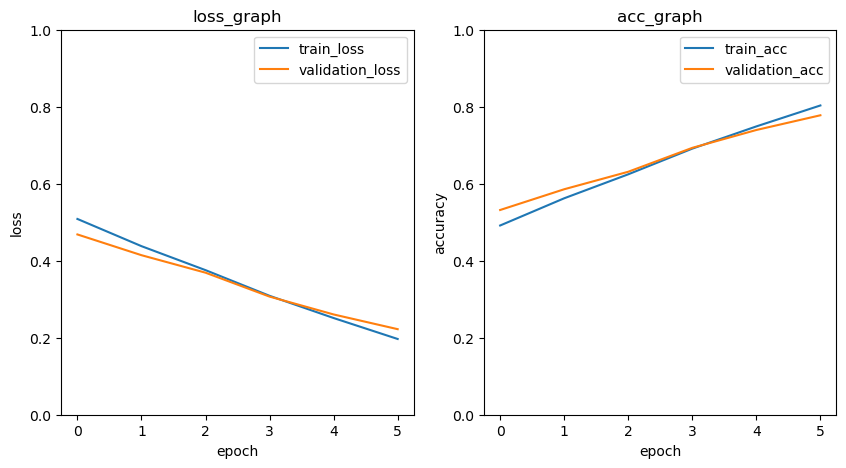

epoch: 7/30 Step: 666 dice_loss : 0.1584 dice_score: 0.8416: 100%|██████████| 665/665 [02:20<00:00,  4.73it/s]
Validation epoch: 7/30 Step: 84 dice_loss : 0.1819  dice_score: 0.8181: 100%|██████████| 83/83 [00:05<00:00, 15.60it/s]
epoch: 8/30 Step: 666 dice_loss : 0.1270 dice_score: 0.8730: 100%|██████████| 665/665 [02:20<00:00,  4.75it/s]
Validation epoch: 8/30 Step: 84 dice_loss : 0.1711  dice_score: 0.8289: 100%|██████████| 83/83 [00:05<00:00, 15.51it/s]
epoch: 9/30 Step: 666 dice_loss : 0.1071 dice_score: 0.8929: 100%|██████████| 665/665 [02:20<00:00,  4.73it/s]
Validation epoch: 9/30 Step: 84 dice_loss : 0.1710  dice_score: 0.8290: 100%|██████████| 83/83 [00:05<00:00, 15.67it/s]
epoch: 10/30 Step: 666 dice_loss : 0.0925 dice_score: 0.9075: 100%|██████████| 665/665 [02:20<00:00,  4.73it/s]
Validation epoch: 10/30 Step: 84 dice_loss : 0.1822  dice_score: 0.8178: 100%|██████████| 83/83 [00:05<00:00, 15.27it/s]
epoch: 11/30 Step: 666 dice_loss : 0.0874 dice_score: 0.9126: 100%|███████

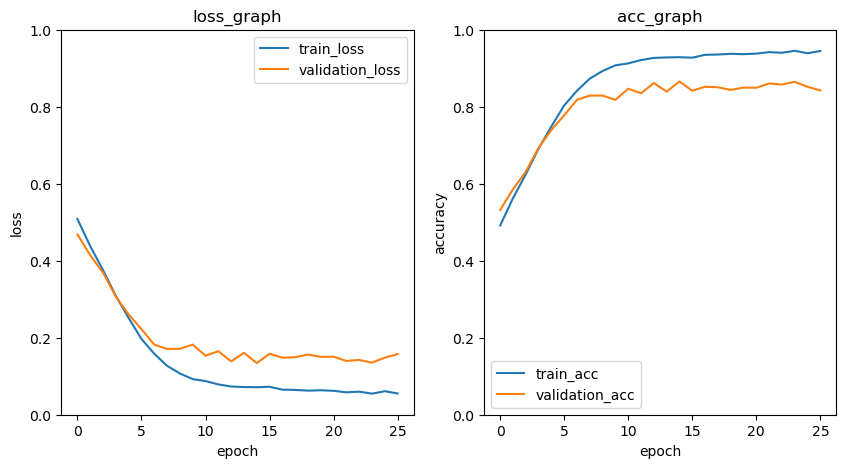

epoch: 27/30 Step: 666 dice_loss : 0.0548 dice_score: 0.9452: 100%|██████████| 665/665 [02:22<00:00,  4.66it/s]
Validation epoch: 27/30 Step: 84 dice_loss : 0.1613  dice_score: 0.8387: 100%|██████████| 83/83 [00:05<00:00, 15.29it/s]
epoch: 28/30 Step: 666 dice_loss : 0.0560 dice_score: 0.9440: 100%|██████████| 665/665 [02:20<00:00,  4.72it/s]
Validation epoch: 28/30 Step: 84 dice_loss : 0.1473  dice_score: 0.8527: 100%|██████████| 83/83 [00:05<00:00, 15.68it/s]
epoch: 29/30 Step: 666 dice_loss : 0.0576 dice_score: 0.9424: 100%|██████████| 665/665 [02:21<00:00,  4.70it/s]
Validation epoch: 29/30 Step: 84 dice_loss : 0.1508  dice_score: 0.8492: 100%|██████████| 83/83 [00:05<00:00, 14.40it/s]
epoch: 30/30 Step: 666 dice_loss : 0.0503 dice_score: 0.9497: 100%|██████████| 665/665 [02:20<00:00,  4.72it/s]
Validation epoch: 30/30 Step: 84 dice_loss : 0.1637  dice_score: 0.8363: 100%|██████████| 83/83 [00:05<00:00, 15.51it/s]


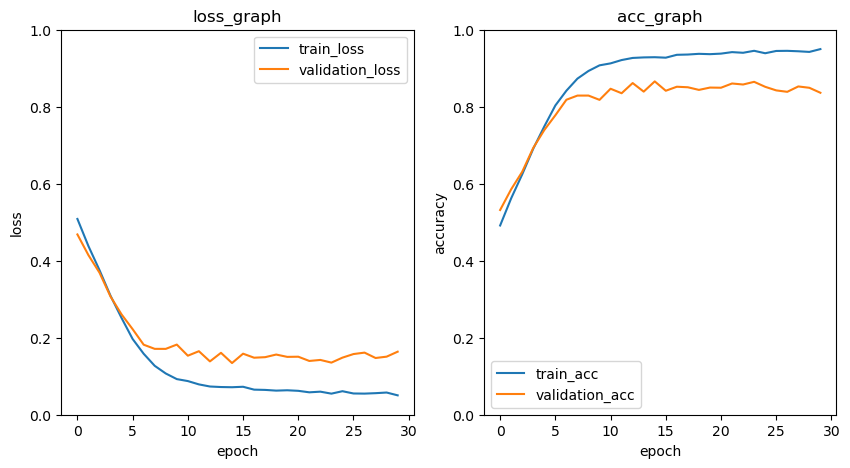

batch size= 16
image size= 512
learning rate= 0.0001


In [13]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(30):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y,num_classes=3) # cost 구함
        acc=1-dice_loss(predict, y,num_classes=3)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{30} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y,num_classes=3) # cost 구함
            acc=1-dice_loss(predict, y,num_classes=3)
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"Validation epoch: {epoch+1}/{30} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/NestedUNet_3class_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%20==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 16')
print('image size= 512')
print('learning rate= 0.0001')